In [1]:
import os
import pandas as pd
from decimal import Decimal


from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta
import time


# Numerical methods for American options

#from functions.BS_pricer import BS_pricer
#from functions.Parameters import Option_param
#from functions.Processes import Diffusion_process
#from functions.cython.cython_functions import PSOR

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))


In [236]:
ticker = 'GOOG'
rfr = []

# 2 weeks, 1m, 3m, 6m, 1yr
expiration_datetime = []
expiration_datetime.append(datetime(2020, 12, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 1, 8, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 3, 19, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 10, 15, 0, 0, tzinfo=timezone.utc))

In [237]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_timestamp = []
for x in expiration_datetime:
    expiration_timestamp.append(int(x.timestamp()))

print(expiration_timestamp)
for x in expiration_timestamp:
    print(datetime.fromtimestamp(x)) # this is in UTC, add 5 hours to this to get EST

[1608249600, 1610064000, 1616112000, 1623974400, 1634256000]
2020-12-17 19:00:00
2021-01-07 19:00:00
2021-03-18 20:00:00
2021-06-17 20:00:00
2021-10-14 20:00:00


## Below we create the data fram from the yahoo historical data.

Download historical stock price data for Google (GOOG). I get a past year's worth from (https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

In [238]:
# 1

# download annual historical data for the stock

# stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
stock_price_path = "price_data/{}.csv".format(ticker)
options_data_path = []
for x in expiration_timestamp:
    options_data_path.append('https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, x, ticker))

df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))

# percent change in price from day before
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)
#get rid of first day in data, since we can't find price from day before
df = df.dropna()
df = df.drop(['Open','High','Low','Close'],axis=1)

# get options data, save
print(options_data_path)
options_data = []
for i,x in enumerate(options_data_path):
    options_df_list = pd.read_html(x)
    collection_date = str(datetime.now().date() - timedelta(days=1))
    data_path1 = "price_data/{}/{}_{}_calls.csv".format(collection_date, ticker, expiration_timestamp[i])
    data_path = "price_data/{}/{}_{}_puts.csv".format(collection_date, ticker, expiration_timestamp[i])
    options_df_list[0] = pd.read_csv(data_path1)
    options_df_list[1] = pd.read_csv(data_path)
    options_data.append(options_df_list) # returns two dataframes, for calls and puts
#    collection_date = str(datetime.now().date())
#    save_path = "price_data/{}".format(collection_date)
#    if not os.path.exists(save_path):
#        os.makedirs(save_path)
#    options_df_list[0].to_csv("price_data/{}/{}_{}_calls.csv".format(collection_date, ticker, expiration_timestamp[i]))
#    options_df_list[1].to_csv("price_data/{}/{}_{}_puts.csv".format(collection_date, ticker, expiration_timestamp[i]))
#    time.sleep(1)

options_data
    
calls_df = []
puts_df = []
for x in options_data:

    x[0]['Volume'] = x[0]['Volume'].replace('-','0')
    x[0] = x[0].replace('-',np.NaN)
    x[1]['Volume'] = x[1]['Volume'].replace('-','0')
    x[1] = x[1].replace('-',np.NaN)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].str.slice(stop=-1)
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].str.slice(stop=-1)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].astype(float)/100
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].astype(float)/100
    
    
    #x[1]['Implied Volatility'] = x[1]['Implied Volatility'].replace(0,10**(-3))
    #x[0]['Implied Volatility'] = x[0]['Implied Volatility'].replace(0,10**(-3))
    
    x[1] = x[1][x[1]['Implied Volatility'] != 0].reset_index()
    x[0] = x[0][x[0]['Implied Volatility'] != 0].reset_index()

 
    # code for filtering the options data to be only actively traded options

#    x[0] = x[0][(x[0]['Open Interest'].astype('int') > 15)].reset_index()
#    x[0] = x[0][(x[0]['Volume'].astype('int') > 1)].reset_index()
#    x[1] = x[1][(x[1]['Open Interest'].astype('int') > 15)].reset_index()
#    x[1] = x[1][(x[1]['Volume'].astype('int') > 1)].reset_index()
    
    calls_df.append(x[0])
    puts_df.append(x[1])

##add the new item, the Mid Price
for df_list in [calls_df, puts_df]:
    for x in df_list:
        x['Mid Price'] = (x['Ask'] + x['Bid'])/2
#print(df)
#print(calls_df)
#print(puts_df)

['https://finance.yahoo.com/quote/GOOG/options?date=1608249600&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1610064000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1616112000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1623974400&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1634256000&p=GOOG']


In [274]:
#print(puts_df[1])

In [239]:
# 2
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1]
rfr_df.head()

,Date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,12/01/20,0.07,0.07,0.09,0.10,0.12,0.17,0.22,0.42,0.68,0.92,1.46,1.66
1,12/02/20,0.07,0.08,0.09,0.10,0.11,0.16,0.22,0.42,0.69,0.95,1.50,1.70
2,12/03/20,0.08,0.08,0.08,0.09,0.10,0.16,0.21,0.40,0.67,0.92,1.46,1.67
3,12/04/20,0.07,0.07,0.09,0.10,0.11,0.16,0.21,0.42,0.70,0.97,1.53,1.73
4,12/07/20,0.09,0.08,0.08,0.10,0.10,0.14,0.20,0.40,0.67,0.94,1.49,1.69


<AxesSubplot:title={'center':'Treasury Curve for 12/04/20'}>

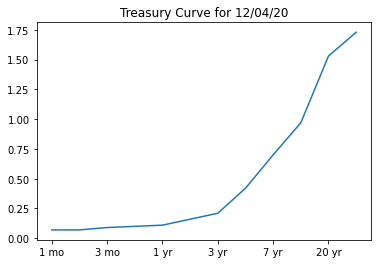

In [240]:
# next we plot the rfr

# find the date from this data
rfr_date = rfr_df.iloc[3][0]

cur_rfr = rfr_df.iloc[3][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [241]:
# 3
# BSM model algorithm using SciPy for the normal distribution
# Explicit formula for solving European Option Prices

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    # 9am market open on NYSE
    return (expiration_datetime_utc - datetime(2020, 12,7,hour=2, tzinfo=timezone.utc)).days / 252


In [242]:
# 4

# the rfr should vary with time, not be constant.
rfr = []
for x in [1,1,3,4,5]:
    rfr.append(rfr_df.iloc[3][x].astype(float))
    
# Adjust the 2-week expiration rfr
rfr[0] = rfr[0]/2
    
cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = []
for x in expiration_datetime:
    time_to_expiration.append(get_time_to_expiration(x))

# Calculate the volatility as the annualized standard deviation of the stock returns
## The stock market has had a crazy year, perhaps we want the volatility to be measured only in the last 6 months. 
sigma = np.sqrt(252) * df['returns'].std()

## Do interest rates need to be adjusted with day counts? need to look into this

rfr_time = tuple(zip(time_to_expiration, rfr))

for x in rfr_time:
    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, sigma: {}'.format(cur_stock_price, x[0], x[1], sigma))


cur_stock_price: 1826.77002, time to expiration: 0.03968253968253968, rfr: 0.035, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.12301587301587301, rfr: 0.07, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.4007936507936508, rfr: 0.09, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.7619047619047619, rfr: 0.1, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 1.2341269841269842, rfr: 0.11, sigma: 0.3787231343934279


In [243]:
## numpy doesnt support decimal

def float2dec(value):
    # "Convert `value` to Decimal cents."
    return Decimal(value).quantize(Decimal('0.00001'))

In [244]:
## has problems

def my_round(value, N):
    value = np.asarray(value).copy()
    zero_mask = (value == 0)
    value[zero_mask] = 1.0
    sign_mask = (value < 0)
    value[sign_mask] *= -1
    exponent = np.ceil(np.log10(value))
    result = 10**exponent*np.round(value*10**(-exponent), N)
    result[sign_mask] *= -1
    result[zero_mask] = 0.0
    return result

In [245]:
# 5

# binomial trees model for American Options

def price_american_binomial_tree(S0, K, T, r, sig, payoff, N):
    
    #dT = T / N                             # Delta t
    dT = float(T) / N                             # Delta t

    u = np.exp(sig * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 
    
    f = lambda x: float2dec(x)
    V = np.zeros(N+1) # initialize the price vector
    #for i in V:
    #    i = float2dec(i)
    #V = f(V)
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compound return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
        #V = my_round(V,5)
        #V = np.around(V,5)

    elif payoff =="put":
        V[:] = np.maximum(K-S_T, 0.0)
        #V = my_round(V,5)
        #V = np.around(V,5)


    for i in range(N-1, -1, -1):

        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        #V = my_round(V,5)
        #V = np.around(V,5)
        S_T = S_T * u                                        # it is a tricky way to obtain the price at the previous time step
        #S_T = my_round(S_T,5)
        #S_T = np.around(S_T,5)
        if payoff=="call":
            V = np.maximum( V, S_T-K )
            #V = np.around(V,5)
        elif payoff=="put":
            V = np.maximum( V, K-S_T )
            #V = np.around(V, 5)
    
    return V[0]


def accurate_price_american_binomial_tree(S0, K, T, r, sig, payoff, N):
    
    
    #dT = T / N                             # Delta t
    dT = float(T) / N                             # Delta t

    u = np.exp(sig * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 
    
    f = lambda x: float2dec(x)
    V = np.zeros(N+1) # initialize the price vector
    #for i in V:
    #    i = float2dec(i)
    #V = f(V)
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compound return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
        #V = my_round(V,5)
        #V = np.around(V,5)

        #print(V.dtype)
        #for i in V:
        #    i = float2dec(i)
        #print(V.dtype)
    elif payoff =="put":
        V[:] = np.maximum(K-S_T, 0.0)
        #V = my_round(V,5)
        #V = np.around(V,5)


    for i in range(N-1, -1, -1):

        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        #V = my_round(V,5)
        V = np.around(V,5)
        S_T = S_T * u                                        # it is a tricky way to obtain the price at the previous time step
        #S_T = my_round(S_T,5)
        S_T = np.around(S_T,5)
        if payoff=="call":
            V = np.maximum( V, S_T-K )
            V = np.around(V,5)
        elif payoff=="put":
            V = np.maximum( V, K-S_T )
            V = np.around(V, 5)
    
    return V[0]

In [246]:
# 6

## test the code

S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility


price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 10000)

In [247]:
## test the code with more accuracy

S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility
             # number of periods or number of time steps  

accurate_price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 10000)

In [248]:
S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility
call_expected = black_scholes(S0, K, T, r, sigma, option_type='call')
print(call_expected)

19.551925807665825


In [278]:
# plot as we vary N

iterations = [500,1000, 2000, 4000, 8000, 16000, 25000]
prices = []
runtimes = []

for N in iterations:
    start = time.perf_counter()
    price = price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = N)
    runtimes.append(time.perf_counter() - start)
    prices.append(price)

df_btree = pd.DataFrame({'N':iterations, 'price':prices, 'runtime':runtimes})
df_btree.head()

,N,price,runtime
0,500,13.265501,0.006148
1,1000,13.267589,0.013938
2,2000,13.268633,0.034493
3,4000,13.269155,0.105780
4,8000,13.269416,0.417226


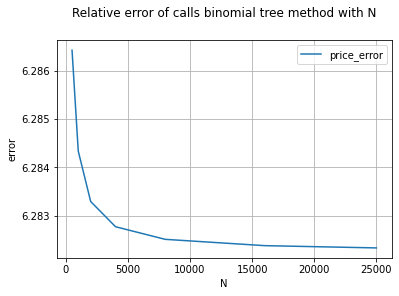

In [279]:
df_btree['price_error'] = call_expected - df_btree['price']
ax1 = df_btree.plot(x='N',y=['price_error'],grid = True)
ax1.set_title("Relative error of calls binomial tree method with N", y=1.08)
ax1.set_ylabel("error")
plt.savefig('bin_tree_error.png')

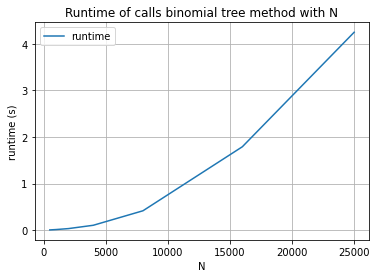

In [280]:
df_btree.plot(grid = True, x='N', y =['runtime'], ylabel='runtime (s)', xlabel='N', title = 'Runtime of calls binomial tree method with N')
plt.savefig('bin_tree_runtime.png')

In [281]:
# plot as we vary N

iterations = [500,1000, 2000, 4000, 8000, 16000, 25000]
prices = []
runtimes = []

for N in iterations:
    start = time.perf_counter()
    price = accurate_price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = N)
    runtimes.append(time.perf_counter() - start)
    prices.append(price)

df_btree = pd.DataFrame({'N':iterations, 'price':prices, 'runtime':runtimes})
df_btree.head()

,N,price,runtime
0,500,13.26552,0.116580
1,1000,13.26764,0.428694
2,2000,13.26866,1.659924
3,4000,14.78553,6.287568
4,8000,17.50613,22.415762


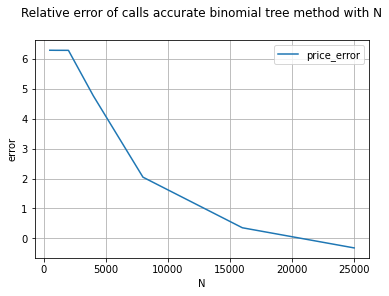

In [282]:
df_btree['price_error'] = call_expected - df_btree['price']
ax1 = df_btree.plot(x='N',y=['price_error'],grid = True)
ax1.set_title("Relative error of calls accurate binomial tree method with N", y=1.08)
ax1.set_ylabel("error")
plt.savefig('bin_tree_error_acc.png')

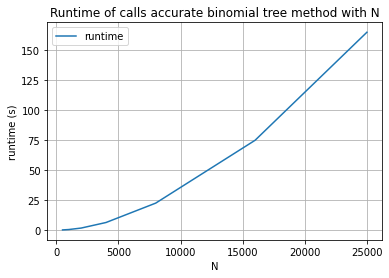

In [283]:
df_btree.plot(grid = True, x='N', y =['runtime'], ylabel='runtime (s)', xlabel='N', title = 'Runtime of calls accurate binomial tree method with N')
plt.savefig('bin_tree_runtime_acc.png')

In [256]:
# Function for to PDE or tree method

def price_american(S0, K, T, r, sigma, payoff, model='binomial_tree'):
    
    if model == 'binomial_tree':
        ## N = 10000 hardcoded, as we see error is less than 10e-3
        return price_american_binomial_tree(S0, K, T, r, sigma, payoff=payoff, N=10000)
    elif model == 'PDE':
        return price_american_PDE(S0, K, T, r, sigma, payoff=payoff, N_space = 4000, N_time = 2000)


In [257]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_american(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type, model):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
    list_estimates_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    #step = 1

    # run BSM for different strikes
    #for x in range(strike_start_idx,strike_end_idx, step):
    for x in range(strike_start_idx,strike_end_idx):
        index.append(x)
        value_s = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                payoff = option_type,
                                model = model)
        list_estimates.append(value_s)
        
        # same calcs but with implied vol
        value_s_implied = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                payoff = option_type,
                                model = model)
        list_estimates_implied.append(value_s_implied)

        
        
    # merge the real and computed dataframes to compare results
    price_estimates = pd.DataFrame(data=list_estimates, index=index)
    price_estimates_implied = pd.DataFrame(data=list_estimates_implied, index=index)
    price_estimates.rename(columns={price_estimates.columns[0]: 'Estimate'},inplace = True)
    price_estimates_implied.rename(columns={price_estimates_implied.columns[0]: 'Estimate With IV'},inplace = True)

    df_estimate = options_df.copy(deep=True)
    df_estimate = df_estimate.loc[:, df.columns.intersection(['Strike','Mid Price','Last Price'])]
    
    df_estimate = df_estimate.merge(price_estimates, right_index = True, left_index = True)
    df_estimate = df_estimate.merge(price_estimates_implied, right_index = True, left_index = True)

    return df_estimate

Wall time: 0 ns


cur_stock_price: 1826.77002, time to expiration: 0.03968253968253968, rfr: 0.035, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.12301587301587301, rfr: 0.07, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.4007936507936508, rfr: 0.09, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.7619047619047619, rfr: 0.1, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 1.2341269841269842, rfr: 0.11, vol: 0.3787231343934279
Wall time: 14min 13s


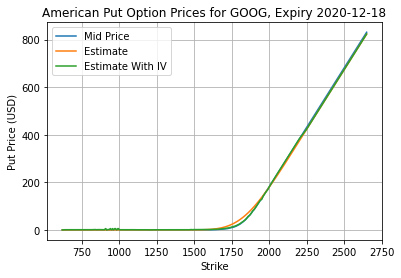

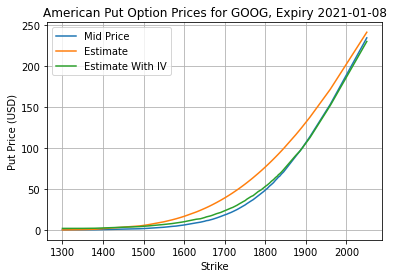

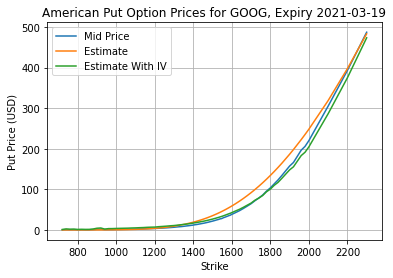

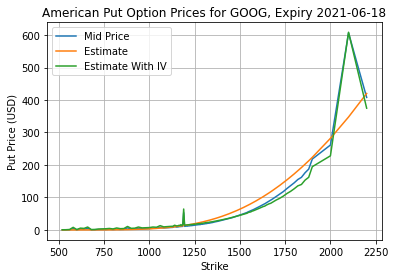

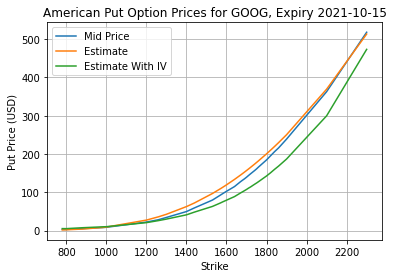

In [331]:
%%time

#store a list of these estimates so I don't need to run it again
american_put_estimates = []

#print(puts_df[0])

for i,df in enumerate(puts_df):
    option_type = 'put'
    df_estimate_american = calculate_prices_across_strikes_american(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    american_put_estimates.append(df_estimate_american)
    
    df_estimate_american.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate', 'Estimate With IV'], title='American Put Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()),ylabel='Put Price (USD)',grid=True)
    plt.savefig('est_puts_{}_{}.png'.format(ticker, expiration_datetime[i].date()))
    


cur_stock_price: 1826.77002, time to expiration: 0.03968253968253968, rfr: 0.035, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.12301587301587301, rfr: 0.07, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.4007936507936508, rfr: 0.09, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.7619047619047619, rfr: 0.1, vol: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 1.2341269841269842, rfr: 0.11, vol: 0.3787231343934279
Wall time: 7min 50s


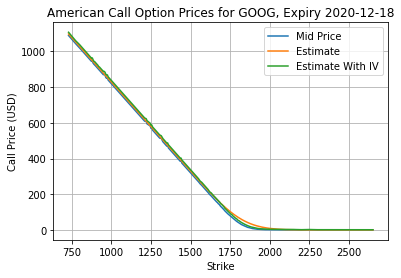

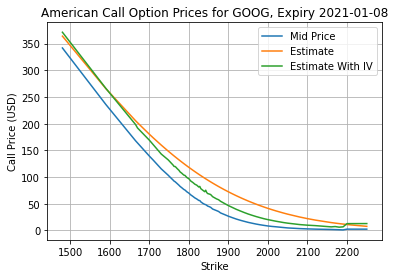

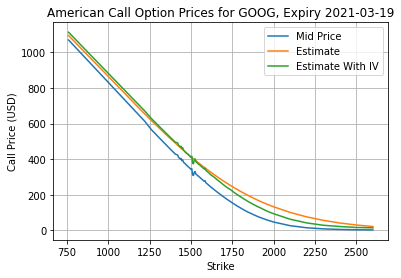

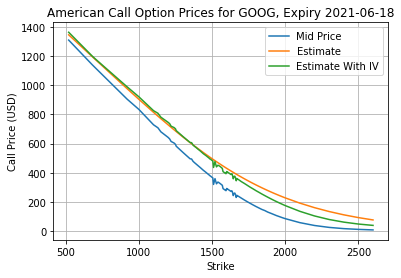

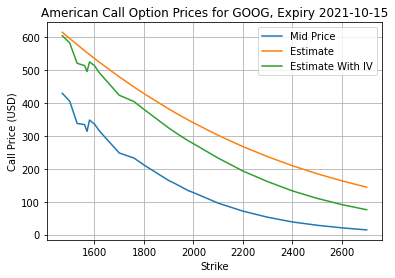

In [330]:
%%time

#store a list of these estimates so I don't need to run it again
american_call_estimates = []

#print(puts_df[0])

for i,df in enumerate(calls_df):
    option_type = 'call'
    df_estimate_american = calculate_prices_across_strikes_american(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    american_call_estimates.append(df_estimate_american)
    
    df_estimate_american.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate', 'Estimate With IV'], title='American Call Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()),grid=True, ylabel = 'Call Price (USD)')
    plt.savefig('est_calls_{}_{}.png'.format(ticker, expiration_datetime[i].date()))

    

## We find the percent error in the price of the Estimate and Estimate With IV

In [346]:
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [american_put_estimates, american_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate Error"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate'])/df['Estimate']))*100

In [347]:
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [american_put_estimates, american_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate With IV Error"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate With IV'])/df['Estimate With IV']))*100

## Plotting the percent error in Estimate and Estimates With IV for American Puts

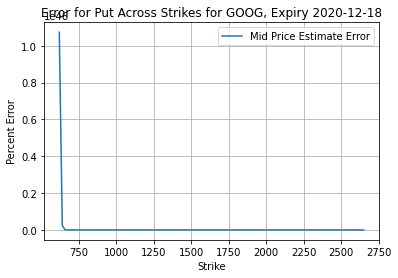

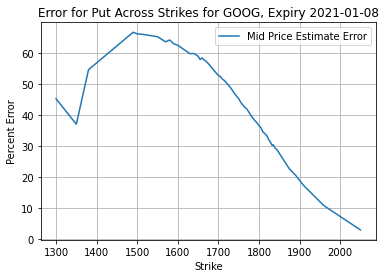

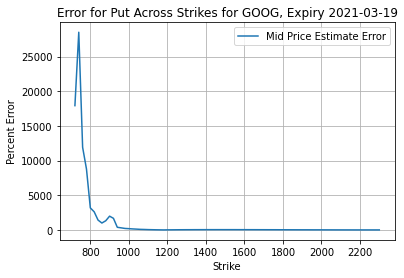

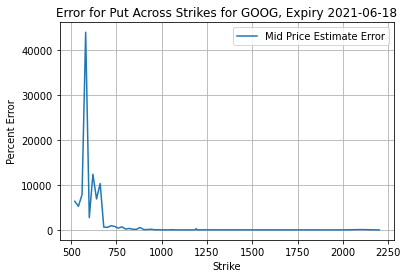

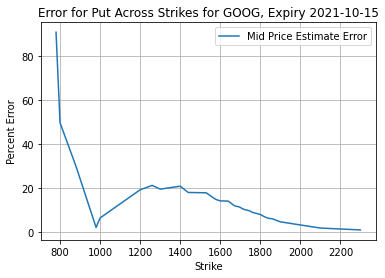

In [319]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error','Last Price Estimate Error'],title='Estimate Error for Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error'],title='Error for Put Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()),grid = True, ylabel = 'Percent Error')
    plt.savefig('err_puts_{}_{}.png'.format(ticker, expiration_datetime[i].date()))

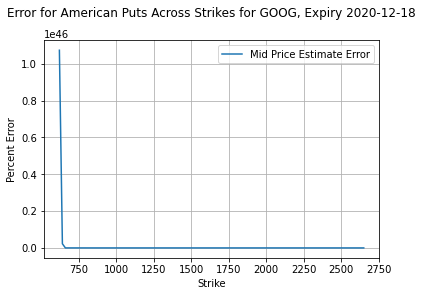

In [320]:
ax1=american_put_estimates[0].plot(x='Strike',y=['Mid Price Estimate Error'],grid = True, ylabel = 'Percent Error')
ax1.set_title('Error for American Puts Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[0].date()), y=1.08)
plt.savefig('err_puts_{}_{}.png'.format(ticker, expiration_datetime[0].date()))

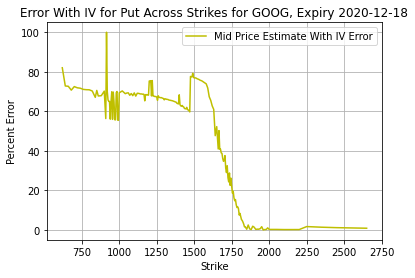

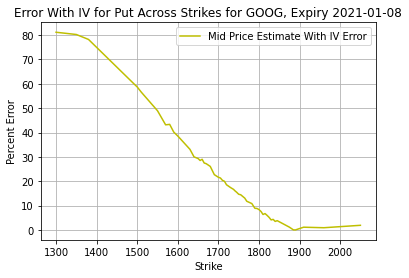

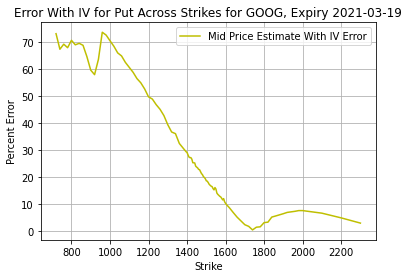

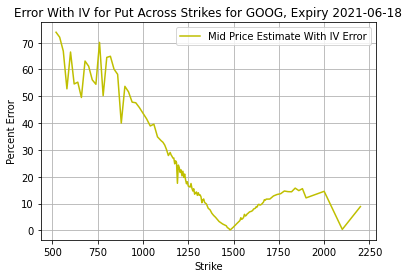

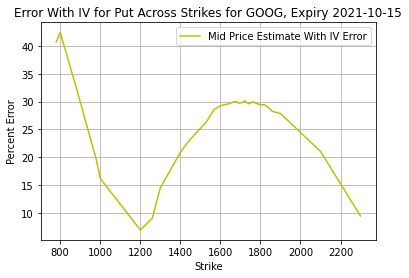

In [321]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error'],title='Error With IV for Put Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()), color = 'y',grid = True, ylabel = 'Percent Error')
    plt.savefig('err_IV_puts_{}_{}.png'.format(ticker, expiration_datetime[i].date()))

## Plotting the percent error in Estimate and Estimates With IV for American Calls

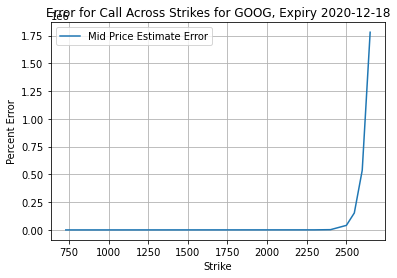

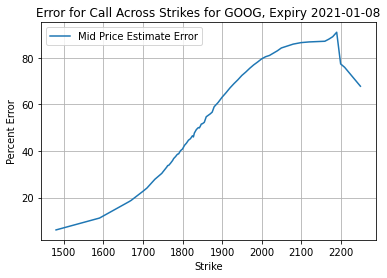

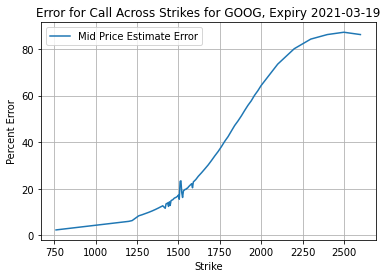

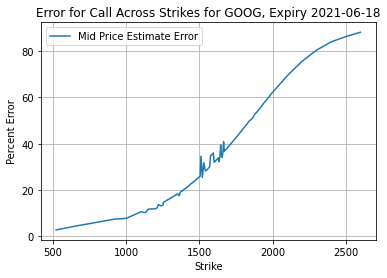

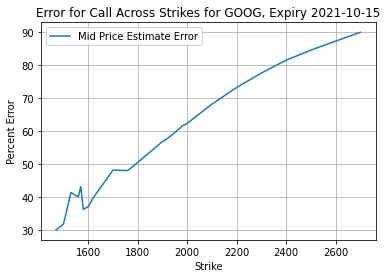

In [322]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error','Last Price Estimate Error'],title='Estimate Error for Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error'],title='Error for Call Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()),grid = True, ylabel = 'Percent Error')
    plt.savefig('err_calls_{}_{}.png'.format(ticker, expiration_datetime[i].date()))

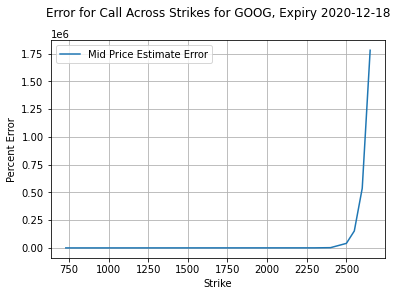

In [323]:
ax1=american_call_estimates[0].plot(x='Strike',y=['Mid Price Estimate Error'],grid = True, ylabel = 'Percent Error')
ax1.set_title('Error for Call Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[0].date()), y=1.08)
plt.savefig('err_calls_{}_{}.png'.format(ticker, expiration_datetime[0].date()))

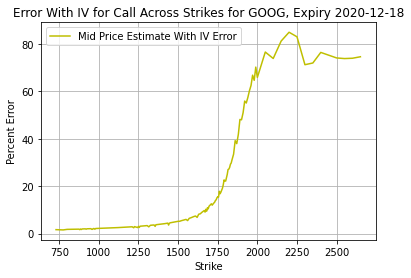

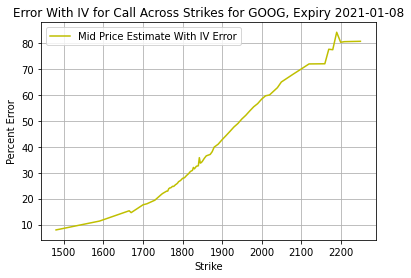

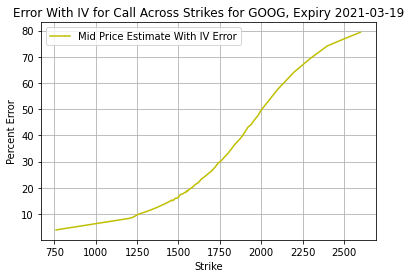

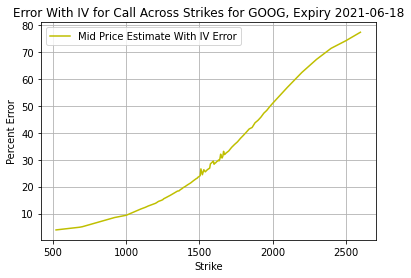

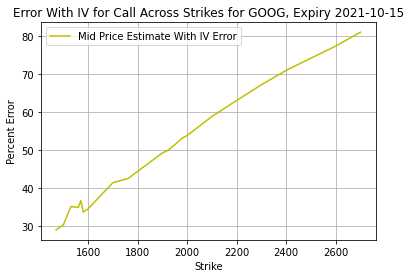

In [324]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error'],title='Error With IV for Call Across Strikes for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()), color='y', grid = True, ylabel = 'Percent Error')
    ax1.grid(True)
    plt.savefig('err_IV_calls_{}_{}.png'.format(ticker, expiration_datetime[i].date()))


## Finding more Error Statistics for the Estimate Error

In [269]:
# median and IQR percent error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_error(df):
    
    predictions, targets = df['Estimate'], df['Mid Price']
#     percent_error = ((abs(targets - predictions)/targets))*100
    percent_error = df['Mid Price Estimate Error']
    Q1 = percent_error.quantile(0.25)
    Q3 = percent_error.quantile(0.75)
    IQR = Q3 - Q1
    
    print('Median Error: {}, IQR of error: {}, RMSE: {}'.format(percent_error.median(), IQR, rmse(predictions, targets)))

print('calls')
for i in range(0,5):
#     print(puts_estimate_df[i]['Mid Price estimate error'].describe())
    get_error(american_call_estimates[i])
print('puts')
for i in range(0,5):
    get_error(american_put_estimates[i])

calls
Median Error: 2.782305176453451, IQR of error: 29.297827892307794, RMSE: 14.393115895716809
Median Error: 51.1439864687765, IQR of error: 37.37987672503037, RMSE: 40.880069520127805
Median Error: 20.566690175951194, IQR of error: 23.086575553916326, RMSE: 73.46442520421691
Median Error: 31.9879321980844, IQR of error: 21.94406987362286, RMSE: 125.77712238810199
Median Error: 53.76739031693259, IQR of error: 28.352526144648436, RMSE: 202.9361391011083
puts
Median Error: 1916.079242936981, IQR of error: 1315290016.3514035, RMSE: 7.075669785266851
Median Error: 45.67909595541187, IQR of error: 23.620768480291567, RMSE: 21.66306460513123
Median Error: 37.16743474830053, IQR of error: 9.349759696933074, RMSE: 15.472577532202843
Median Error: 26.544441657765937, IQR of error: 7.301458450271486, RMSE: 26.74037150720716
Median Error: 11.495570438772832, IQR of error: 10.416722472418321, RMSE: 13.470412663551352


## Finding more Error Statistics for the Estimate Error With IV

In [270]:
# median and IQR percent error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_error(df):
    
    predictions, targets = df['Estimate With IV'], df['Mid Price']
#     percent_error = ((abs(targets - predictions)/targets))*100
    percent_error = df['Mid Price Estimate With IV Error']
    Q1 = percent_error.quantile(0.25)
    Q3 = percent_error.quantile(0.75)
    IQR = Q3 - Q1
    
    print('Median Error: {}, IQR of error: {}, RMSE: {}'.format(percent_error.median(), IQR, rmse(predictions, targets)))

print('calls')
for i in range(0,5):
#     print(puts_estimate_df[i]['Mid Price estimate error'].describe())
    get_error(american_call_estimates[i])
print('puts')
for i in range(0,5):
    get_error(american_put_estimates[i])

calls
Median Error: 5.012893575833771, IQR of error: 15.595320311398428, RMSE: 15.288535385688101
Median Error: 34.14203133182916, IQR of error: 29.568196763404238, RMSE: 22.17236590243188
Median Error: 18.777522154656552, IQR of error: 15.280367136581376, RMSE: 62.87689430140354
Median Error: 26.866904578854793, IQR of error: 15.24765638248492, RMSE: 105.48704421940151
Median Error: 46.813852023551945, IQR of error: 24.124979056030014, RMSE: 152.74500197969576
puts
Median Error: 64.99398085477762, IQR of error: 43.420984385460365, RMSE: 2.0131624715389127
Median Error: 16.422048691484544, IQR of error: 22.80586949235483, RMSE: 4.074091718737916
Median Error: 22.342078914518705, IQR of error: 37.888480640521486, RMSE: 5.724065586739918
Median Error: 14.02700743475691, IQR of error: 20.37198906061077, RMSE: 7.5667496775436325
Median Error: 29.265592118808353, IQR of error: 7.850878122894564, RMSE: 30.8752095220597


## Visulization of the IV versus our naive volatility

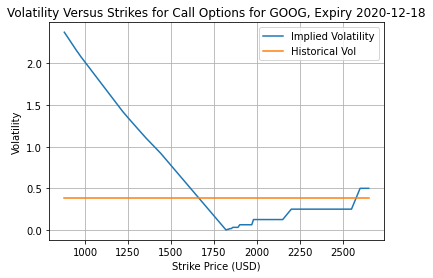

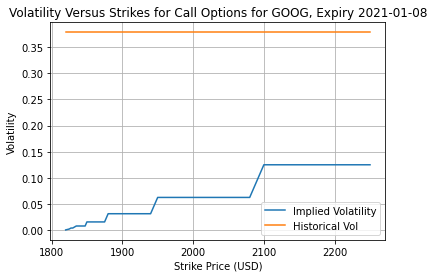

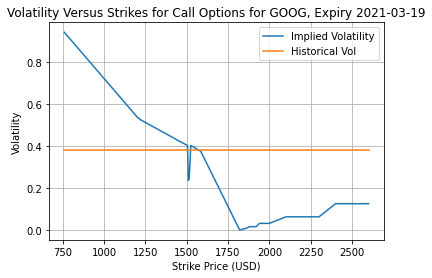

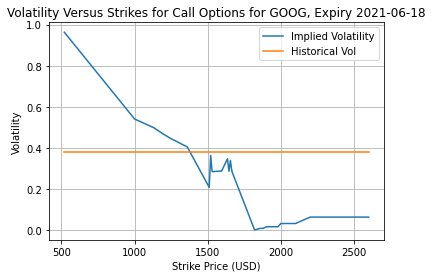

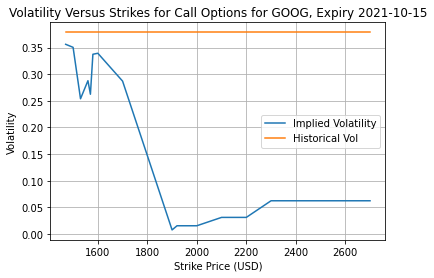

In [18]:
for i in range(0,5):
    calls_df[i]['Historical Vol'] = sigma
    calls_df[i].plot(x='Strike',y=['Implied Volatility','Historical Vol'], ylabel = 'Volatility', xlabel = 'Strike Price (USD)', grid=True, title='Volatility Versus Strikes for Call Options for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

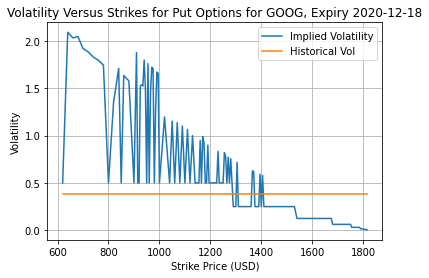

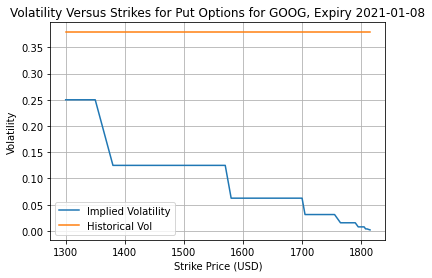

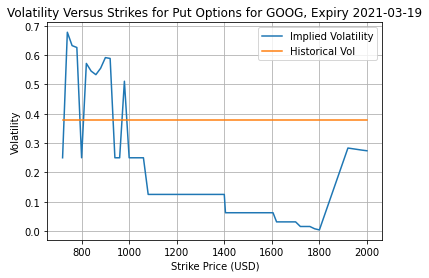

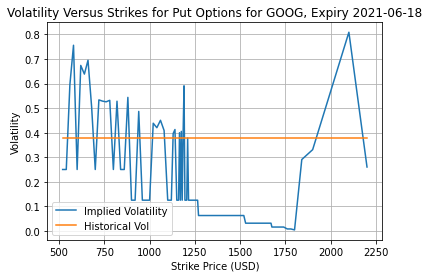

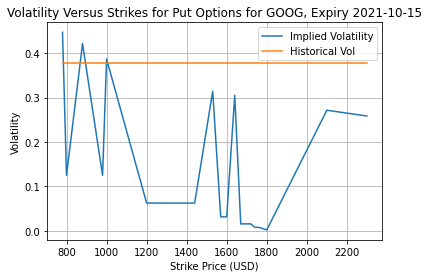

In [19]:
for i in range(0,5):
    puts_df[i]['Historical Vol'] = sigma
    puts_df[i].plot(x='Strike',y=['Implied Volatility','Historical Vol'], ylabel = 'Volatility', xlabel = 'Strike Price (USD)', grid=True, title='Volatility Versus Strikes for Put Options for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))

## Here is code for doing the same for European Options

In [332]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_european(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type, model):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
    list_estimates_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    #step = 1

    # run BSM for different strikes
    #for x in range(strike_start_idx,strike_end_idx, step):
    for x in range(strike_start_idx,strike_end_idx):
        index.append(x)
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                option_type = option_type)
        list_estimates.append(value_s)
        
        # same calcs but with implied vol
        value_s_implied = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                option_type = option_type)
        list_estimates_implied.append(value_s_implied)

        
        
    # merge the real and computed dataframes to compare results
    price_estimates = pd.DataFrame(data=list_estimates, index=index)
    price_estimates_implied = pd.DataFrame(data=list_estimates_implied, index=index)
    price_estimates.rename(columns={price_estimates.columns[0]: 'Estimate (EU)'},inplace = True)
    price_estimates_implied.rename(columns={price_estimates_implied.columns[0]: 'Estimate With IV (EU)'},inplace = True)

    df_estimate = options_df.copy(deep=True)
    df_estimate = df_estimate.loc[:, df.columns.intersection(['Strike','Mid Price', 'Last Price'])]
    
    df_estimate = df_estimate.merge(price_estimates, right_index = True, left_index = True)
    df_estimate = df_estimate.merge(price_estimates_implied, right_index = True, left_index = True)

    return df_estimate

Wall time: 0 ns


## Below I will recalculate the European Options Data

cur_stock_price: 1826.77002, time to expiration: 0.03968253968253968, rfr: 0.035, vol: 0.3787231343934279


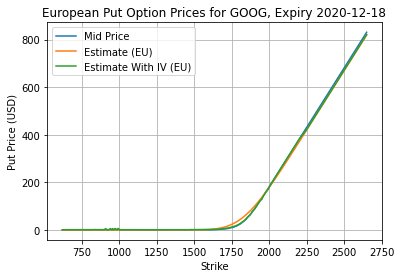

cur_stock_price: 1826.77002, time to expiration: 0.12301587301587301, rfr: 0.07, vol: 0.3787231343934279


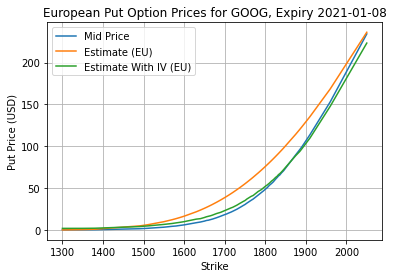

cur_stock_price: 1826.77002, time to expiration: 0.4007936507936508, rfr: 0.09, vol: 0.3787231343934279


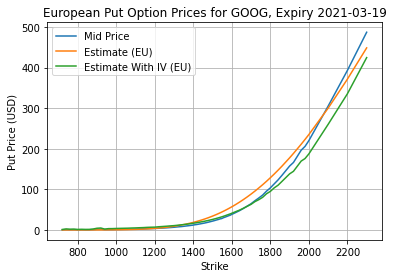

cur_stock_price: 1826.77002, time to expiration: 0.7619047619047619, rfr: 0.1, vol: 0.3787231343934279


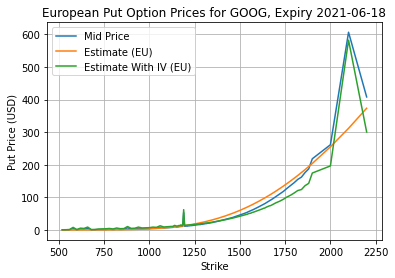

cur_stock_price: 1826.77002, time to expiration: 1.2341269841269842, rfr: 0.11, vol: 0.3787231343934279


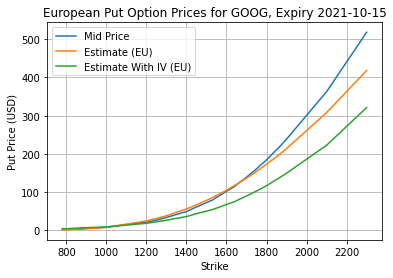

Wall time: 866 ms


In [333]:
%%time

#store a list of these estimates so I don't need to run it again
european_put_estimates = []

#print(puts_df[0])

for i,df in enumerate(puts_df):
    option_type = 'put'
    df_estimate_european = calculate_prices_across_strikes_european(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    european_put_estimates.append(df_estimate_european)
    
    ax1 = df_estimate_european.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate (EU)', 'Estimate With IV (EU)'], title='European Put Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Put Price (USD)')
    plt.show()
    

cur_stock_price: 1826.77002, time to expiration: 0.03968253968253968, rfr: 0.035, vol: 0.3787231343934279


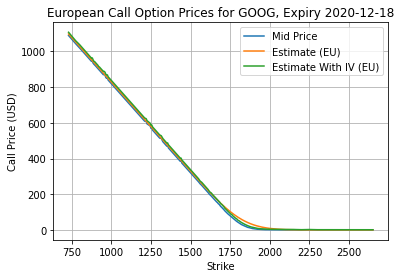

cur_stock_price: 1826.77002, time to expiration: 0.12301587301587301, rfr: 0.07, vol: 0.3787231343934279


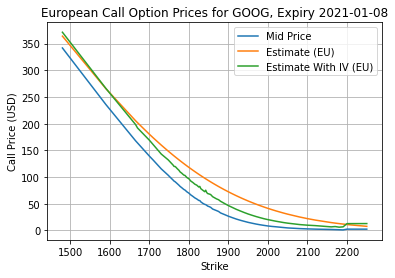

cur_stock_price: 1826.77002, time to expiration: 0.4007936507936508, rfr: 0.09, vol: 0.3787231343934279


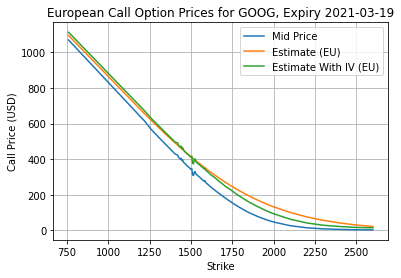

cur_stock_price: 1826.77002, time to expiration: 0.7619047619047619, rfr: 0.1, vol: 0.3787231343934279


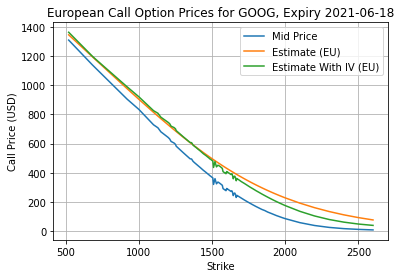

cur_stock_price: 1826.77002, time to expiration: 1.2341269841269842, rfr: 0.11, vol: 0.3787231343934279


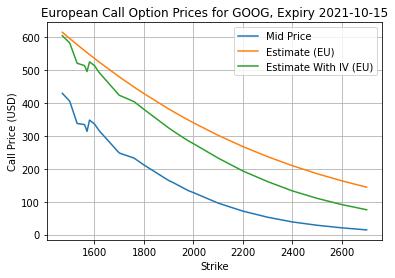

Wall time: 770 ms


In [341]:
%%time

#store a list of these estimates so I don't need to run it again
european_call_estimates = []

#print(puts_df[0])

for i,df in enumerate(calls_df):
    option_type = 'call'
    df_estimate_european = calculate_prices_across_strikes_european(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    european_call_estimates.append(df_estimate_european)
    
    ax1 = df_estimate_european.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate (EU)', 'Estimate With IV (EU)'], title='European Call Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Call Price (USD)')
    plt.show()
    

In [342]:
## Calculating the error forthe put prices

features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [european_put_estimates, european_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate Error (EU)"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate (EU)'])/df['Estimate (EU)']))*100

for feature in features:
    for df_list in [european_put_estimates, european_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate With IV Error (EU)"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate With IV (EU)'])/df['Estimate With IV (EU)']))*100

## We will compare the percent error in the data using implied volatility of the European and American Puts 

In [343]:
## Compare American and European Error

#df_estimate_american['european_estimate'] = df_estimate_european['estimate']
#df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']

for i in range(0,5):
    american_call_estimates[i] = american_call_estimates[i].merge(european_call_estimates[i], right_on = ['Strike', 'Last Price', 'Mid Price'], left_on = ['Strike', 'Last Price', 'Mid Price'])
    american_put_estimates[i] = american_put_estimates[i].merge(european_put_estimates[i], right_on = ['Strike', 'Last Price', 'Mid Price'], left_on = ['Strike', 'Last Price', 'Mid Price'])


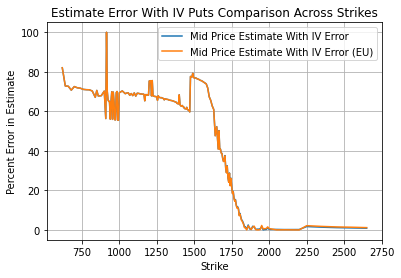

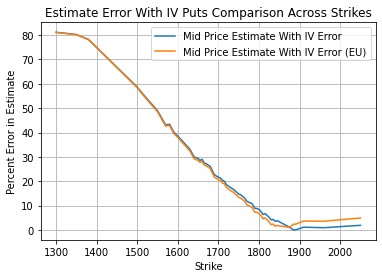

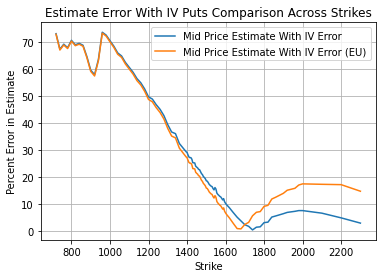

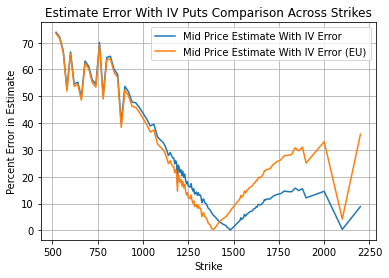

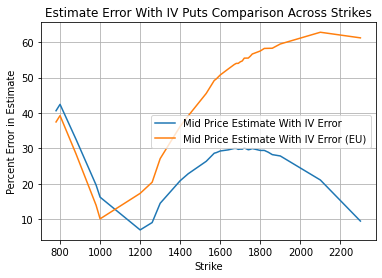

In [348]:
for i in range(0,5):
    #american_put_estimates[i].rename()
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error', 'Mid Price Estimate With IV Error (EU)'],title='Estimate Error With IV Puts Comparison Across Strikes',ylabel='Percent Error in Estimate',grid = True)
    plt.savefig('err_comp_puts_{}_{}.png'.format(ticker, expiration_datetime[i].date()))


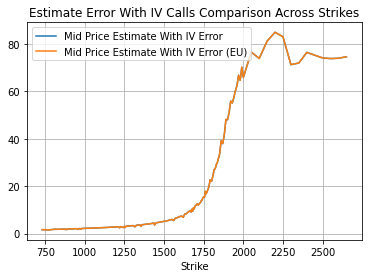

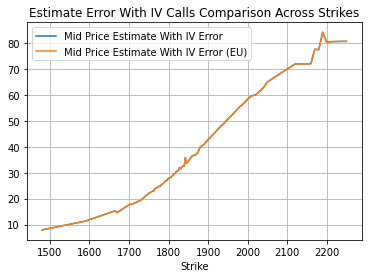

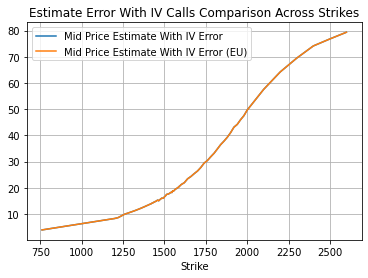

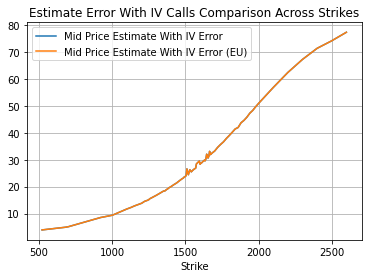

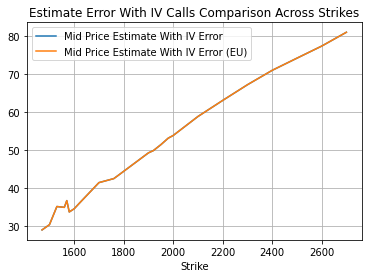

In [349]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error', 'Mid Price Estimate With IV Error (EU)'],title='Estimate Error With IV Calls Comparison Across Strikes', grid = True)
    plt.savefig('err_comp_calls_{}_{}.png'.format(ticker, expiration_datetime[i].date()))
